## Facts

* one AOI is seemingly 1540 x 1540 tiles
    * These are approx 10m x 10m

* One landing strip is maximum approx. 500m long and 30m wide

* GMF model is trained on images of size slightly below 200 x 200. We can give inputs to the premade microsoft thing of 224 x 224.

### Geo Foundation Model
https://arxiv.org/pdf/2302.04476

For pretraining, we employ 8 NVIDIA V100 GPUs with
a batch size of 2048 (128 per GPU) and the image size
of 192×192. All pretraining settings are the same as in
[43]. For downstream tasks, 4 NVIDIA A10G GPUs are
employed. During the pretraining stage, we utilize RGB
bands as they are most commonly available among data
sources and tasks.

In [1]:
import ee
import geopandas as gpd
import folium
import os

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Load the runway shapefile
shapefile_path = '../pac_2024_training/pac_2024_training.shp'
gdf = gpd.read_file(shapefile_path)

# Ensure CRS is WGS84
if gdf.crs != 'EPSG:4326':
    gdf = gdf.to_crs('EPSG:4326')

# Select the first runway
runway = gdf.iloc[0]
runway_geometry = runway.geometry.__geo_interface__

# Get the year from the runway attributes
year = runway['yr']

# Define the time interval
start_date = f'{year}-01-01'
end_date = f'{year}-12-31'
# # Define the date range
# start_date = '2020-01-01'
# end_date = '2020-12-31'

# Define the area of interest
aoi = ee.Geometry.Polygon(runway_geometry['coordinates'])

# Load Sentinel-2 image collection
collection = (ee.ImageCollection('COPERNICUS/S2_SR')
              .filterDate(start_date, end_date)
              .filterBounds(aoi)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
            #   .sort('CLOUDY_PIXEL_PERCENTAGE')
              )

# Get the first image TODO - change to mean!!!
image = collection.first()

# Check if image is available
if image:
    # Apply cloud masking function
    def maskS2clouds(image):
        qa = image.select('QA60')
        # Bits 10 and 11 are clouds and cirrus
        cloudBitMask = 1 << 10
        cirrusBitMask = 1 << 11
        # Both flags should be set to zero, indicating clear conditions
        mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
        return image.updateMask(mask).divide(10000)

    # Apply cloud masking and scaling
    image = maskS2clouds(image)

    # Select bands and visualization parameters
    bands = ['B4', 'B3', 'B2']  # True color
    vis_params = {
        'min': 0,
        'max': 0.3,  # Adjusted for scaled reflectance values
        'bands': bands
    }

    print("Geometry Type:", runway.geometry.geom_type)
    print("Coordinates:", runway_geometry['coordinates'])

    # Get the centroid of the runway geometry for map centering
    centroid = runway.geometry.centroid
    center_lat = centroid.y
    center_lon = centroid.x

    # Create a folium map centered on the runway
    m = folium.Map(location=[center_lat, center_lon], zoom_start=15)

    # Define a function to add Earth Engine layers to Folium
    def add_ee_layer(self, ee_image_object, vis_params, name):
        try:
            map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
            folium.TileLayer(
                tiles=map_id_dict['tile_fetcher'].url_format,
                attr='Google Earth Engine',
                name=name,
                # tile = folium.TileLayer(
                # tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                # attr = 'Esri',
                # name = 'Esri Satellite',
                overlay=True,
                control=True
            ).add_to(self)
        except Exception as e:
            print(f"Could not display {name}: {e}")

    # Add EE drawing method to Folium
    folium.Map.add_ee_layer = add_ee_layer

    # Add the image layer to the map
    m.add_ee_layer(image, vis_params, 'Sentinel-2')

    # Add the runway geometry to the map
    folium.GeoJson(runway_geometry, name='Runway',
                   style_function=lambda x: {'color': 'red', 'weight': 2}).add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    # Display the map (in Jupyter Notebook)
    display(m)
else:
    print("No images found for the specified date range and area.")


/home/emil/Desktop/secret-runway-detection/.venv/lib/python3.12/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Geometry Type: LineString
Coordinates: ((-70.08928656863503, -13.129844039931504), (-70.08052787039317, -13.128251134052485), (-70.08052787039317, -13.128251134052485))


In [2]:
import geopandas as gpd
from shapely.geometry import Polygon, Point  # Imported Point for centroid
import matplotlib.pyplot as plt
import contextily as ctx
import re
import os


def parse_tile_identifier(tile_id):
    """
    Parses the tile identifier to extract AOI year, month, row, and column.

    Parameters:
    - tile_id (str): Tile identifier in the format 'Tileaoi_YY_MM_row_col'

    Returns:
    - year (str): Four-digit year
    - month (str): Two-digit month
    - row (int): Tile row index
    - col (int): Tile column index
    """
    pattern = r'Tileaoi_(\d{2})_(\d{2})_(\d+)_(\d+)'
    match = re.match(pattern, tile_id)
    if not match:
        raise ValueError(
            "Tile identifier does not match the expected format 'Tileaoi_YY_MM_row_col'.")
    yy, mm, row, col = match.groups()
    year = f"20{yy}"
    month = mm
    return year, month, int(row), int(col)


def calculate_tile_extent(aoi_bounds, row, col, total_rows, total_cols):
    """
    Calculates the spatial extent (bounding box) of a specific tile within the AOI.

    Parameters:
    - aoi_bounds (tuple): (minx, miny, maxx, maxy) of the AOI
    - row (int): Tile row index
    - col (int): Tile column index
    - total_rows (int): Total number of tile rows in the AOI
    - total_cols (int): Total number of tile columns in the AOI

    Returns:
    - tile_polygon (Polygon): Shapely Polygon of the tile's bounding box
    """
    minx, miny, maxx, maxy = aoi_bounds
    tile_width = (maxx - minx) / total_cols
    tile_height = (maxy - miny) / total_rows

    tile_minx = minx + (col - 1) * tile_width
    tile_maxx = minx + col * tile_width
    tile_miny = miny + (row - 1) * tile_height
    tile_maxy = miny + row * tile_height

    tile_polygon = Polygon([
        (tile_minx, tile_miny),
        (tile_minx, tile_maxy),
        (tile_maxx, tile_maxy),
        (tile_maxx, tile_miny),
        # (tile_minx, tile_miny)
    ])

    return tile_polygon


def inspect_tile(tile_id, shapefiles_dir, total_rows, total_cols):
    """
    Inspects a specific tile by plotting it within the corresponding AOI shapefile.

    Parameters:
    - tile_id (str): Tile identifier (e.g., 'Tileaoi_21_03_1047_1231')
    - shapefiles_dir (str): Directory containing AOI shapefiles
    - total_rows (int): Total number of tile rows in the AOI
    - total_cols (int): Total number of tile columns in the AOI
    """
    # Parse the tile identifier
    year, month, row, col = parse_tile_identifier(tile_id)
    print(
        f"AOI Year: {year}, AOI Month: {month}, Tile Row: {row}, Tile Column: {col}")

    # Determine the AOI shapefile path
    aoi_filename = f"aoi_{year}_{month}.shp"
    aoi_path = os.path.join(shapefiles_dir, aoi_filename)

    if not os.path.exists(aoi_path):
        raise FileNotFoundError(f"AOI shapefile not found: {aoi_path}")

    # Load the AOI shapefile
    aoi_gdf = gpd.read_file(aoi_path)
    aoi_bounds = aoi_gdf.total_bounds  # [minx, miny, maxx, maxy]

    # Calculate the tile's spatial extent
    tile_polygon = calculate_tile_extent(
        aoi_bounds, row, col, total_rows, total_cols)

    # Create a GeoDataFrame for the tile
    tile_gdf = gpd.GeoDataFrame([{'geometry': tile_polygon}], crs=aoi_gdf.crs)

    # Reproject to Web Mercator for basemap compatibility
    aoi_gdf = aoi_gdf.to_crs(epsg=3857)
    tile_gdf = tile_gdf.to_crs(epsg=3857)

    # Check if the tile is within the AOI
    is_within = tile_gdf.within(aoi_gdf.unary_union).iloc[0]
    print(f"Is the tile within the AOI? {'Yes' if is_within else 'No'}")

    # ----------------------------
    # Added: Create and Plot Circle around Tile
    # ----------------------------
    # Calculate AOI dimensions
    aoi_width = aoi_bounds[2] - aoi_bounds[0]
    aoi_height = aoi_bounds[3] - aoi_bounds[1]
    aoi_average = (aoi_width + aoi_height) / 2

    # Define circle radius as 1/8 of the AOI's average dimension
    circle_radius = aoi_average / 8

    # Get the centroid of the tile
    tile_centroid = tile_gdf.geometry.centroid.iloc[0]

    # Create a circular polygon around the centroid
    circle = tile_centroid.buffer(circle_radius)

    # Create a GeoDataFrame for the circle
    circle_gdf = gpd.GeoDataFrame([{'geometry': circle}], crs=aoi_gdf.crs)

    # ----------------------------
    # Added: Create and Plot Circle around Tile
    # ----------------------------
    # Calculate AOI dimensions
    aoi_width = aoi_bounds[2] - aoi_bounds[0]
    aoi_height = aoi_bounds[3] - aoi_bounds[1]
    aoi_average = (aoi_width + aoi_height) / 2

    # Define circle radius as 1/8 of the AOI's average dimension
    circle_radius = aoi_average / 8

    # Get the centroid of the tile
    tile_centroid = tile_gdf.geometry.centroid.iloc[0]

    # Create a circular polygon around the centroid
    circle = tile_centroid.buffer(circle_radius)

    # Create a GeoDataFrame for the circle
    circle_gdf = gpd.GeoDataFrame([{'geometry': circle}], crs=aoi_gdf.crs)

    # ----------------------------
    # Plot AOI, Tile, Circle, and Zoomed Tile
    # ----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))

    # Plot 1: Full AOI with Tile and Circle
    aoi_gdf.plot(ax=axes[0], color='lightblue',
                 edgecolor='black', label='AOI', alpha=0.5)
    if is_within:
        tile_gdf.plot(ax=axes[0], color='red',
                      edgecolor='black', alpha=0.5, label='Tile')
    else:
        tile_gdf.plot(ax=axes[0], color='gray', edgecolor='black',
                      alpha=0.5, label='Tile (Outside AOI)')
    circle_gdf.plot(ax=axes[0], facecolor='none',
                    edgecolor='yellow', linewidth=2, label='Tile Circle')
    ctx.add_basemap(axes[0], source=ctx.providers.Esri.WorldImagery, zoom=12)
    axes[0].set_title(f'Inspecting {tile_id} within {aoi_filename}')
    axes[0].set_xlabel('Easting')
    axes[0].set_ylabel('Northing')
    axes[0].legend()

    # Plot 2: Zoomed-in Tile
    tile_gdf.plot(ax=axes[1], color='lightblue',
                  edgecolor='black', alpha=0.5, label='Tile')
    # bounds = tile_polygon.bounds
    # padding_coef = 1
    # axes[1].set_xlim(bounds[0] - padding_coef * (bounds[2] - bounds[0]), bounds[2] + padding_coef * (bounds[2] - bounds[0]))
    # axes[1].set_ylim(bounds[1] - padding_coef * (bounds[3] - bounds[1]), bounds[3] + padding_coef * (bounds[3] - bounds[1]))
    ctx.add_basemap(
        axes[1],
        source=ctx.providers.Esri.WorldImagery,
        zoom=12)  # Higher zoom level for detail
    axes[1].set_title(f'Zoomed-in View of {tile_id}')
    axes[1].set_xlabel('Easting')
    axes[1].set_ylabel('Northing')

    plt.tight_layout()
    plt.show()

    return is_within

# ----------------------------
# Example Usage
# ----------------------------


if __name__ == "__main__":
    # Define the tile identifier you want to inspect
    tile_identifier = 'Tileaoi_21_03_1047_1231'  # Replace with your tile ID

    # Define the directory containing AOI shapefiles
    shapefiles_dir = 'shp_test_AOIs/shp'  # Adjust if different

    # Define the total number of rows and columns in the AOI grid
    # **Important:** Replace these with actual numbers based on your tiling system
    total_tile_rows = 2000  # Example value
    total_tile_cols = 2000  # Example value

    # Inspect the tile
    try:
        within_aoi = inspect_tile(
            tile_identifier, shapefiles_dir, total_tile_rows, total_tile_cols)
    except Exception as e:
        print(f"Error: {e}")

AOI Year: 2021, AOI Month: 03, Tile Row: 1047, Tile Column: 1231
Error: AOI shapefile not found: shp_test_AOIs/shp/aoi_2021_03.shp


Training Data Loaded Successfully!

First Five Rows of Training Data:
   id    yr     largo  Activo  \
0   1  2023   968.918       0   
1   2  2022  1105.491       0   
2   3  2015   985.018       0   
3   4  2020   681.914       0   
4   5  2020   699.552       0   

                                            geometry  
0  LINESTRING (-70.08929 -13.12984, -70.08053 -13...  
1  LINESTRING (-69.16744 -13.62068, -69.17286 -13...  
2  LINESTRING (-69.14225 -13.69451, -69.14190 -13...  
3  LINESTRING (-69.07844 -13.78790, -69.08404 -13...  
4  LINESTRING (-69.07838 -13.78788, -69.08279 -13...  

Training Data Information:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        154 non-null    int64   
 1   yr        154 non-null    int64   
 2   largo     154 non-null    float64 
 3   Activo    154 non-null    int64   
 4   geometry  154 no

/tmp/ipykernel_483554/3548578260.py:111: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


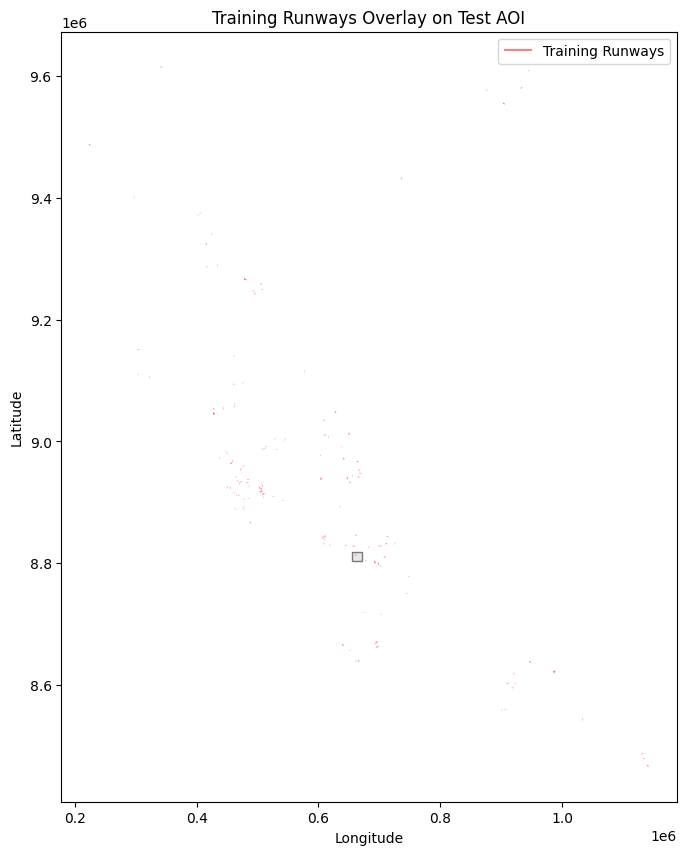


Number of Training Runways Intersecting aoi_2021_04.shp: 1

=== Summary ===

- **Training Data**: Contains polygons of known clandestine runways with attributes such as year of detection. Used to train the detection model.
- **Test AOIs**: Define areas where the model needs to detect potential runways for specified years.
- **Submission CSVs**:
    - `input.csv`: Labeled tile data for training/validation.
    - `SampleSubmission.csv`: Template showing the required submission format with a large number of rows.
    
**Relationships**:
- Train the model using training shapefiles and input.csv.
- Apply the model to test AOIs to predict runways.
- Generate a reduced submission file (~200,000 rows) based on predictions, focusing on detected runways and their buffer regions.



In [3]:
# ============================================
# GeoAI Amazon Basin Secret Runway Detection
# Data Inspection Script
# ============================================

# ----------------------------
# 1. Environment Setup
# ----------------------------

# Install required libraries (Uncomment if running for the first time)
# !pip install geopandas matplotlib pandas

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

# ----------------------------
# 2. Inspecting Training Data
# ----------------------------

# a. Define the Path to the Training Shapefile
training_shapefile_path = os.path.join(
    '../pac_2024_training', 'pac_2024_training.shp')

if not os.path.exists(training_shapefile_path):
    print(f"Training shapefile not found at: {training_shapefile_path}")
    sys.exit(1)

# b. Load the Training Shapefile
training_data = gpd.read_file(training_shapefile_path)
print("Training Data Loaded Successfully!")

# c. Inspect the First Few Rows
print("\nFirst Five Rows of Training Data:")
print(training_data.head())

# d. Check Data Structure and CRS
print("\nTraining Data Information:")
print(training_data.info())

print("\nTraining Data CRS:")
print(training_data.crs)

# e. Explore Attribute Columns
print("\nTraining Data Columns:")
print(training_data.columns)

if 'year' in training_data.columns:
    print("\nYear of Detection Counts:")
    print(training_data['year'].value_counts())
else:
    print("\nNo 'year' column found in training data.")

# ----------------------------
# 3. Inspecting Test AOIs
# ----------------------------

# a. List All Test Shapefiles
test_shapefiles_dir = os.path.join('../shp_test_AOIs', 'shp')

if not os.path.isdir(test_shapefiles_dir):
    print(f"Test shapefiles directory not found at: {test_shapefiles_dir}")
    sys.exit(1)

test_shapefiles = [f for f in os.listdir(
    test_shapefiles_dir) if f.endswith('.shp')]

print(f"\nFound {len(test_shapefiles)} Test Shapefiles:")
for shp in test_shapefiles:
    print(f"- {shp}")

# b. Load and Inspect a Specific Test Shapefile
if not test_shapefiles:
    print("No test shapefiles found to inspect.")
    sys.exit(1)

test_shapefile_name = test_shapefiles[0]
test_shapefile_path = os.path.join(test_shapefiles_dir, test_shapefile_name)

test_data = gpd.read_file(test_shapefile_path)
print(f"\nTest AOI Data Loaded Successfully: {test_shapefile_name}")

# c. Inspect the Test AOI Data
print("\nFirst Five Rows of Test AOI Data:")
print(test_data.head())

print("\nTest AOI Data Information:")
print(test_data.info())

print("\nTest AOI Data CRS:")
print(test_data.crs)


# e. Overlay Training Runways on Test AOI
if training_data.crs != test_data.crs:
    training_data_converted = training_data.to_crs(test_data.crs)
    print("\nConverted training data CRS to match test AOI CRS.")
else:
    training_data_converted = training_data

fig, ax = plt.subplots(figsize=(10, 10))
test_data.plot(ax=ax, color='lightgrey', edgecolor='black',
               alpha=0.5, label='Test AOI')
training_data_converted.plot(
    ax=ax, color='red', edgecolor='black', alpha=0.5, label='Training Runways')
plt.title('Training Runways Overlay on Test AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# f. Spatial Relationship Analysis
intersections = gpd.sjoin(training_data_converted,
                          test_data, how='inner', predicate='intersects')
print(
    f"\nNumber of Training Runways Intersecting {test_shapefile_name}: {len(intersections)}")

# ----------------------------
# 5. Summary and Relationships
# ----------------------------

print("\n=== Summary ===")
print("""
- **Training Data**: Contains polygons of known clandestine runways with attributes such as year of detection. Used to train the detection model.
- **Test AOIs**: Define areas where the model needs to detect potential runways for specified years.
- **Submission CSVs**:
    - `input.csv`: Labeled tile data for training/validation.
    - `SampleSubmission.csv`: Template showing the required submission format with a large number of rows.
    
**Relationships**:
- Train the model using training shapefiles and input.csv.
- Apply the model to test AOIs to predict runways.
- Generate a reduced submission file (~200,000 rows) based on predictions, focusing on detected runways and their buffer regions.
""")